In [175]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

UsageError: Line magic function `%alive_progress` not found.


In [165]:
names = open('names.txt','r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [166]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [167]:
# build dataset
block_size = 3 # context length: # of characters taken for prediction

def build_dataset(names):
    X, Y = [], []

    for name in names:
        context = [0] * block_size
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr = build_dataset(names[:n1]) # training set 80%
Xdev, Ydev = build_dataset(names[n1:n2]) # dev set 10%
Xte, Yte = build_dataset(names[n2:]) # test set 10%


In [270]:
# network initialization
n_embd = 10 # character embedding dimensionality
n_hid = 200 # # of neurons in hidden layer
gain = 5/3 # recommended gain value for tanh activation function

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),         generator=g) # character embeddings
W1 = torch.randn((block_size * n_embd, n_hid), generator=g) * gain / (block_size * n_embd)**0.5
# batch normalization will cancel out bias term (biased from bnbias)
# b1 = torch.randn((n_hid,),                     generator=g) * 0.01
W2 = torch.randn((n_hid, vocab_size),          generator=g) * gain / (n_hid)**0.5
b2 = torch.zeros((vocab_size,))

# batch normalization parameters
bngain = torch.ones((1, n_hid)) # batch normalization gain
bnbias = torch.zeros((1, n_hid)) # batch normalization bias
bnmean_running = torch.zeros((1, n_hid)) # running mean for batch normalization
bnstd_running = torch.ones((1, n_hid)) # running std for batch normalization

parameters = [C, W1, W2, b2, bngain, bnbias] # parameters to be optimized (removed b1)
for p in parameters:
    p.requires_grad_(True)
print("Number of parameters: ", sum([p.numel() for p in parameters]))

Number of parameters:  12097


In [275]:
# optimization
max_steps = 200000
batch_size = 32
bn_eps = 1e-5 # epsilon for numerical stability in batch normalization (/0 error)
lossi = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] # character embeddings
    embcat = emb.view(emb.shape[0], -1) # concatenate embeddings

    #linear layer
    hpreact = embcat @ W1 #(+ b1) # hidden layer preactivation

    # Batch normalization
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / (bnstdi + bn_eps)) + bnbias # batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # nonlinearity
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # loutput layer
    logits = logits.log_softmax(dim=-1) # normalize with log softmax
    loss = F.cross_entropy(logits, Yb) # loss function
    # backward pass
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad 
        p.grad = None
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())



      0/ 200000: 2.3535
  10000/ 200000: 1.8854
  20000/ 200000: 2.0903
  30000/ 200000: 2.1682
  40000/ 200000: 2.1738
  50000/ 200000: 2.1162
  60000/ 200000: 1.9653
  70000/ 200000: 2.1000
  80000/ 200000: 2.4661
  90000/ 200000: 1.7093
 100000/ 200000: 2.3094
 110000/ 200000: 2.2003
 120000/ 200000: 2.0866
 130000/ 200000: 2.0110
 140000/ 200000: 2.0336
 150000/ 200000: 2.2915
 160000/ 200000: 2.0892
 170000/ 200000: 2.1169
 180000/ 200000: 2.0652
 190000/ 200000: 1.7686


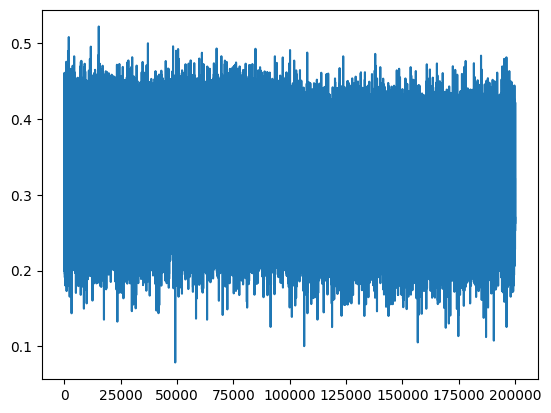

In [276]:
plt.plot(lossi)

In [277]:
# loss evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr,Ytr), 'val': (Xdev,Ydev), 'test': (Xte,Yte)}[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate embeddings
    hpreact = embcat @ W1 #+ b1 # hidden layer preactivation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0530
val loss: 2.1013


In [278]:
# model sampling
@torch.no_grad()
def sample_model(n):
    context = [0] * block_size
    for _ in range(n):
        out = []
        context = [0] * block_size
        while True:
            # forward pass
            emb = C[torch.tensor(context)]
            embcat = emb.view(1, -1) # concatenate embeddings
            hpreact = embcat @ W1 # hidden layer preactivation
            hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalization
            h = torch.tanh(hpreact) # hidden layer activation
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=-1)

            # sampling
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # shift context
            context = context[1:] + [ix]
            if ix == 0:
                break
            out.append(itos[ix])
        print(''.join(out))
sample_model(20)

coura
damirice
memir
brighilandi
tan
dani
ney
yiylahylariel
aug
aireon
nyx
maesemanzellee
jelie
ziarett
mana
pryn
riya
zakhiantraescon
emmeryz
blakeky
